# FIFA World Cup (2022) Monte Carlo Winner Prediction


Aim: to build a predictive algorithm for the outcome of a soccer tournament, in this case applied to the 2022 FIFA World Cup through four major poles:
1. Reliable data for each participating team and its players, on which to base our analysis --> the outcome of games for the past 50 years, as well as their context (friendly vs. FIFA World Cup), rosters, and goals scored. 
2. Building a method for the prediction of the number of goals scored and conceded for each team in any given scenario.
3. Building a poisson regression model to predict the outcome of each game, based on the probabilities obtained from step 2. 
4. Deriving final predicted results for the entirety of the tournament.

#### 1. Data Pre-Processing

The data was imported from Kaggle, where countries are ranked by their respective Soccer Power Index (SPI) ratings. This universally accepted ranking system was designed by ESPN to provide an objective and accurate depiction of a team's current overall skill level. Unlike other systems, such as FIFA rankings, SPI is proactive and predictive. It is intended to forecast which teams will be the most successful in the future, rather than rate the success of teams in the past, which is why this metric was considered audacious to use.

Several factors are taken into account when computing a team's World Cup SPI rating. On the one hand, international match results yield match-based SPI ratings, which account for 75% of the weight of the World Cup SPI rating. On the other hand, the remaining 25% comes from the roster-based SPI rating, derived from both the World Cup roster and club team match results. 

The number of goals scored for each team was considered and adjusted based on the number of red cards and the time each goal was scored. The number of goals expected to be scored was also factored in, based on both shooting attempts made and non-shooting actions taken near the opposite team's goal.

In [2]:
import pandas as pd
import numpy as np
fifa  = pd.read_csv('https://raw.githubusercontent.com/m-selma/Monte_Carlo_Poisson_Predictions/main/data/2022_spi_global_rankings.csv')
print(fifa)

     rank                      name    confed   off   def    spi
0       1                    Brazil  CONMEBOL  3.22  0.30  93.55
1       2                     Spain      UEFA  2.80  0.39  89.51
2       3                   Germany      UEFA  3.17  0.62  88.77
3       4                  Portugal      UEFA  2.79  0.48  87.77
4       5                    France      UEFA  2.77  0.48  87.71
..    ...                       ...       ...   ...   ...    ...
215   216               Timor-Leste       AFC  0.27  5.25   0.69
216   217                     Macau       AFC  0.20  5.01   0.66
217   218  Turks and Caicos Islands  CONCACAF  0.43  6.27   0.47
218   219                     Samoa       OFC  0.20  5.78   0.34
219   220                     Tonga       OFC  0.20  6.08   0.26

[220 rows x 6 columns]


From there, the groups A to H were defined, each comprised of four teams that were qualified to participate in the 2022 FIFA World Cup, along with a list of all participating countries.

In [3]:
group_a = ['Qatar',
           'Ecuador',
           'Senegal',
           'Netherlands']
group_b =['England',
          'Iran',
          'USA',
          'Wales']
group_c =['Argentina',
          'Saudi Arabia',
          'Mexico',
          'Poland' ]
group_d =['France',
          'Australia',
          'Denmark',
          'Tunisia' ]
group_e =['Spain',
          'Costa Rica',
          'Germany',
          'Japan']
group_f =['Belgium',
          'Canada',
          'Morocco',
          'Croatia']
group_g =['Brazil',
          'Serbia',
          'Switzerland',
          'Cameroon' ]
group_h =['Portugal',
          'Ghana',
          'Uruguay',
          'South Korea']

group_list = [group_a, group_b, group_c, group_d, group_e, group_f, group_g, group_h]
teams_to_groups = []
for group in group_list:
    teams_to_groups.append(group)
flat_list = [item for sublist in teams_to_groups for item in sublist]

#### 2. Goal/Score Prediction

A predictive function was then defined, which matched each team in a group against every other team within the same group. In accordance with the World Cup rules, points were assigned as follows: 3 points for a win, 1 point for a tie, and 0 points for a loss. Each team initially began with 0 points, and after every match, the corresponding points were added to the team's total. Ultimately, only the two teams with the highest number of points from each group qualified for the next round.

In [4]:
def value_getter(item):
    return item[1]

def group_stage(group):

    """
    teams in a group must all play eachother.
    a win is worth 3 points
    a tie is worth 1 point
    loss is worth 0 points
    
    teams with the largest two scores advance into the elimintaion round.
    
    :param group: (group of 4 teams)
    :return: two advancing teams
    """
    
    #initialize scores as zero in dict
    group_scores = {}
    for i in range(len(group_a)):
        group_scores[group[i]] = 0

    #head to head matches
    #make a list of winning teams, ties are stored as tuples of teams

    matches = [ PredictScore(group[0],group[1],elimination=False), PredictScore(group[0],group[2],elimination=False), PredictScore(group[0],group[3],elimination=False), PredictScore(group[1],group[2],elimination=False), PredictScore(group[1],group[3],elimination=False), PredictScore(group[2],group[3],elimination=False)]

    #allocate points to teams
    for match in matches:
        if type(match) is tuple:
            group_scores[match[0]] += 1
            group_scores[match[1]] += 1
        else:
            group_scores[match] += 3

    #find the two highest scores in the dictionary
    winners = sorted(group_scores.items(), key=value_getter)[-2:]
    first = winners[0][0]
    second = winners[1][0]

    #check for a tie and run a tie breaker in the event of a tie
    return first, second

In the real world, if two teams are tied in points, the team with the higher number of goals advances. However, for simplicity, we bypassed this situation by introducing an additional step: a tie-breaker "game." This tie-breaker is implemented as a simple boolean function, which operates with a 50/50 chance. It returns either "True" or "False," based on the value of a randomly selected number between 1 and 100.

In [5]:
import random
def tie_break():
    roll = random.randint(1,100)
    if roll <= 50:
        return False
    elif roll >= 51:
        return True

#### 3. Poisson Regression

The function `PredictScore` is used to return the name of the winning team when two team names are provided as input arguments. The number of goals scored and conceded is extracted from the data for each team, or argument. A random Poisson regression is then run, with 10,000 iterations (to eliminate randomness from the results), to obtain a predicted value for the number of goals scored by each team.

From there, a probability table is built to show the likelihood of scoring 0 to 4 goals for each team, along with the probabilities for each scenario (e.g., team A scores 0 goals and team B scores 0 goals; team A scores 1 goal and team B scores 0 goals; team A scores 2 goals and team B scores 0 goals; ... ; team A scores 4 goals and team B scores 4 goals). The probabilities for team A winning, team B winning, and both teams tying are then summed, and the name of the predicted winning team is output.

To illustrate the strategy, consider the example of USA vs. Mexico:

- USA Goals = (USA SPI Goals + Mexico SPI Conceded Goals) / 2
- Mexico Goals = (Mexico SPI Goals + USA SPI Conceded Goals) / 2

> A Poisson regression is run (for both USA and Mexico Goals).

> The likelihoods from the Poisson model are summed to obtain the total odds of each team winning or a tie.

In [6]:
import numpy as np
import collections
from scipy import stats
N = 10000

def PredictScore(home_team,away_team,elimination):

    avg_home_score = fifa.loc[fifa.name == home_team,'off'].values[0]
    avg_away_score = fifa.loc[fifa.name == away_team,'off'].values[0]

    avg_home_goal_conceded = fifa.loc[fifa.name == home_team,'def'].values[0]
    avg_away_goal_conceded = fifa.loc[fifa.name == away_team,'def'].values[0]

    away_goal = np.random.poisson(1/2*(avg_away_score+avg_home_goal_conceded),N)
    home_goal = np.random.poisson(1/2*(avg_home_score+avg_away_goal_conceded),N)

    home_counter = collections.Counter(home_goal)
    away_counter = collections.Counter(away_goal)

    n = 5
    m = 5
    a = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            a[i,j] = (away_counter[i] + home_counter[j])/(10*N)

    tie_odds = a[0,0] + a[1,1] + a[2,2] + a[3,3] + a[4,4]
    home_odds = np.sum(a[0,1:]) + np.sum(a[1,2:]) + np.sum(a[2,3:]) + np.sum(a[3,4:])
    away_odds = np.sum(a[1:,0]) + np.sum(a[2:,1]) + np.sum(a[3:,2]) + np.sum(a[4:,3])

    #tie_odds += 0.05 * np.random.normal(0,1, size=1)
    #home_odds += 0.05 * np.random.normal(0,1, size=1)
    #away_odds += 0.05 * np.random.normal(0,1, size=1)

    if home_odds> away_odds:
        return home_team

    elif tie_odds > home_odds and tie_odds > away_odds and elimination == False:
        return home_team, away_team

    elif tie_odds > home_odds and tie_odds > away_odds and elimination == True:
        if tie_break() == False:
            return home_team
        else:
            return away_team

    else:
        return away_team


Once a function to predict a winner between two teams was established, the overall structure of the competition was defined for the subsequent stages (the round of 16, quarter-finals, semi-finals, and final).

Starting from the initial groups, the previously defined `GroupStage` function was run with the `PredictScore` function and its elimination condition set to "False" (ensuring that teams opposed each other regardless of previous game outcomes, until all configurations were exhausted). This process yielded the names of the two teams advancing to the round of 16 from each group.

Subsequently, the `PredictScore` function was executed again, this time with the elimination condition set to "True." Only the winning teams at this stage proceeded to the round of 8. This strategy was then applied to the round of 8 and the round of 4, respectively, using the winners from each preceding round. The final iteration produced the winner of the final game, which was the output of the `sum_cup` function.

In [8]:
#Group Play
def sim_cup():
    #group play
    group_to_advance = [group_a, group_b, group_c, group_d, group_e, group_f, group_g, group_h]
    teams_to_advance_16 = []
    for group in group_to_advance:
        teams_to_advance_16.append(group_stage(group))


    # Round of 16
    one_16 = PredictScore(teams_to_advance_16[0][0], teams_to_advance_16[1][1], elimination = True)
    two_16 = PredictScore(teams_to_advance_16[2][0], teams_to_advance_16[3][1], elimination = True)

    three_16 = PredictScore(teams_to_advance_16[4][0], teams_to_advance_16[5][1], elimination = True)
    four_16 = PredictScore(teams_to_advance_16[6][0], teams_to_advance_16[7][1], elimination = True)

    five_16 = PredictScore(teams_to_advance_16[1][0], teams_to_advance_16[0][1], elimination = True)
    six_16 = PredictScore(teams_to_advance_16[3][0], teams_to_advance_16[2][1], elimination = True)

    seven_16 = PredictScore(teams_to_advance_16[5][0], teams_to_advance_16[4][1], elimination = True)
    eight_16 = PredictScore(teams_to_advance_16[7][0], teams_to_advance_16[6][1], elimination = True)

    # Round of 8
    one_8 = PredictScore(one_16, two_16, elimination = True)
    two_8 = PredictScore(three_16, four_16, elimination = True)

    three_8 = PredictScore(five_16, six_16, elimination = True)
    four_8 = PredictScore(seven_16, eight_16, elimination = True)

    # Round of 4
    one_4 = PredictScore(one_8, two_8, elimination = True)
    two_4 = PredictScore(three_8, four_8, elimination = True)

    #final
    final = PredictScore(one_4, two_4, elimination = True)
    return final


#### 4. Winner Winner, Chicken Dinner

In this final step, a dictionary was created associating a value of 0 with each team on the list of participating countries. The `sim_cup` function was then run 100 times, effectively simulating the competition 100 times and aggregating the number of times each team was predicted as the winner. The result represents the percentage probability of each team winning the competition, which can then be visualized in the graph provided below.

In [9]:
#MC
final_wins = {}
for i in flat_list:
    final_wins[i] = 0

for i in range(100):
    winner = sim_cup()
    final_wins[winner] += 1

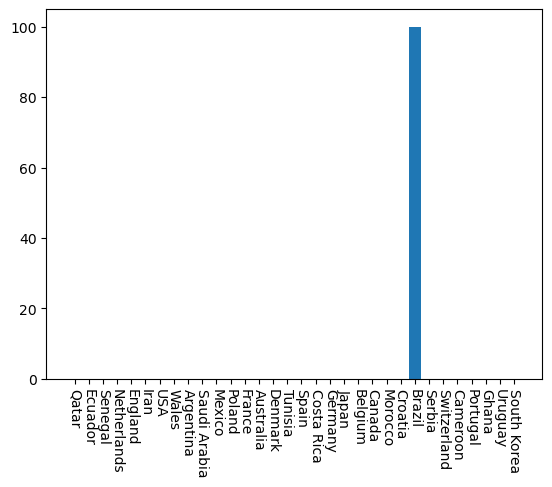

In [14]:
import matplotlib.pyplot as plt
names = final_wins.keys()
values = final_wins.values()
plt.bar(names, values)
plt.xticks(rotation =270)
plt.show()

From this run, the predicted 2022 FIFA World Cup winner was Brazil. 